# Health data analysis

Oura ring data for last 3 years
captures HRV, Sleep, Exercise etc...

In [54]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


## Load Data

In [13]:
df = pd.read_csv('data/data.csv')

## EDA

In [6]:
# look at data
df.head()

,date,Temperature Trend Deviation,Total Burn,Bedtime Start,Long Periods of Inactivity,Inactive Time,Sleep Balance Score,HRV Balance Score,Training Frequency Score,Readiness Score,...,Previous Day Activity Score,REM Sleep Duration,Average MET,Total Sleep Score,Total Bedtime,Sleep Efficiency Score,Recovery Index Score,Training Volume Score,Meet Daily Targets Score,Restless Sleep
0,2020-04-14,NaN,2594,2020-04-13T22:51:07.000-07:00,2,41040,NaN,NaN,100,90.0,...,NaN,6450.0,1.50000,77.0,25740.0,97.0,97.0,99,78,234.0
1,2020-04-15,NaN,2385,2020-04-14T21:36:31.000-07:00,1,42960,NaN,NaN,100,92.0,...,75.0,9000.0,1.37500,96.0,30660.0,100.0,100.0,99,60,279.0
2,2020-04-16,0.04,2440,2020-04-15T22:12:33.000-07:00,0,44700,NaN,NaN,100,79.0,...,79.0,7950.0,1.43750,81.0,28140.0,88.0,80.0,98,43,170.0
3,2020-04-17,0.04,2481,2020-04-16T23:14:24.000-07:00,2,40440,89.0,NaN,100,88.0,...,88.0,7110.0,1.46875,83.0,28140.0,95.0,97.0,98,43,222.0
4,2020-04-18,0.03,2466,2020-04-17T23:41:30.000-07:00,0,24960,83.0,NaN,100,78.0,...,93.0,4620.0,1.43750,74.0,25920.0,93.0,41.0,99,43,168.0


In [7]:
df.isna().sum()/len(df)

date                           0.000000
Temperature Trend Deviation    0.060961
Total Burn                     0.000000
Bedtime Start                  0.043376
Long Periods of Inactivity     0.000000
Inactive Time                  0.000000
Sleep Balance Score            0.045135
HRV Balance Score              0.047479
Training Frequency Score       0.000000
Readiness Score                0.043376
Resting Heart Rate Score       0.044549
Non-wear Time                  0.000000
Temperature Deviation (°C)     0.053341
Steps                          0.000000
Deep Sleep Duration            0.043376
Low Activity Time              0.000000
Average HRV                    0.044549
Respiratory Rate               0.043376
Activity Burn                  0.000000
Deep Sleep Score               0.043376
Total Sleep Duration           0.043376
Restfulness Score              0.043376
Sleep Timin Score              0.043376
Previous Night Score           0.047479
Sleep Latency                  0.043376


In [8]:
# remove NAs
df = df.dropna()

In [96]:
# # check type of data
# df.dtypes

In [10]:
df['date'] = pd.to_datetime(df['date'], utc=True)
df = df.set_index('date')

## Can we identify when I fell sick just by looking at the data?

In [16]:
# remove columns with 'score' in the name

df_copy = df.copy()
df_copy = df_copy.loc[:, ~df_copy.columns.str.contains('score', case=False)]
print("Current Columns: ",df_copy.columns)
print("removed columns: ",df.columns[df.columns.str.contains('score', case=False)])

Current Columns:  Index(['date', 'Temperature Trend Deviation', 'Total Burn', 'Bedtime Start',
       'Long Periods of Inactivity', 'Inactive Time', 'Non-wear Time',
       'Temperature Deviation (°C)', 'Steps', 'Deep Sleep Duration',
       'Low Activity Time', 'Average HRV', 'Respiratory Rate', 'Activity Burn',
       'Total Sleep Duration', 'Sleep Latency', 'Equivalent Walking Distance',
       'Sleep Efficiency', 'Bedtime End', 'Medium Activity Time',
       'Lowest Resting Heart Rate', 'Average Resting Heart Rate', 'Awake Time',
       'Sleep Timing', 'Light Sleep Duration', 'Rest Time',
       'High Activity Time', 'REM Sleep Duration', 'Average MET',
       'Total Bedtime ', 'Restless Sleep'],
      dtype='object')
removed columns:  Index(['Sleep Balance Score', 'HRV Balance Score', 'Training Frequency Score',
       'Readiness Score', 'Resting Heart Rate Score', 'Deep Sleep Score',
       'Restfulness Score', 'Sleep Timin Score', 'Previous Night Score',
       'Temperature Scor

In [17]:
numeric_cols = df_copy.select_dtypes(include=[np.number]).columns.tolist()
# Standardize numeric columns | note that we don't have to import any packages for this.
scaler = StandardScaler() 
df_copy[numeric_cols] = scaler.fit_transform(df_copy[numeric_cols])

In [18]:
df_copy = df_copy.reset_index()

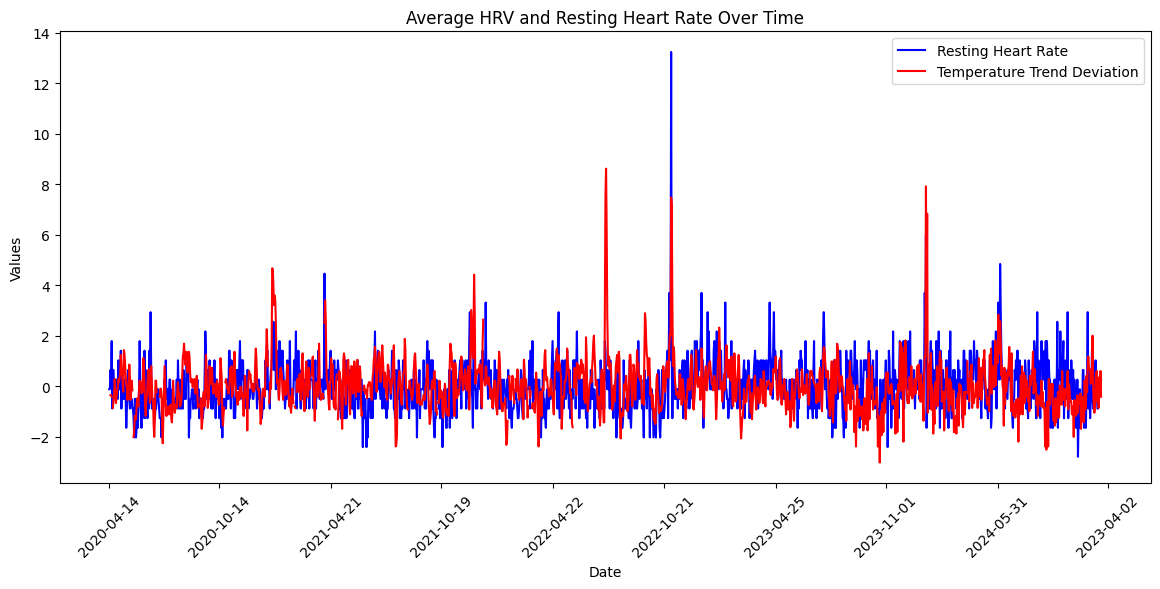

In [24]:
# plot Average HRV and Resting Heart Rate
plt.figure(figsize=(12, 6))
# plt.plot(df_copy['date'], df_copy['Average HRV'], label='Average HRV', color='blue')
plt.plot(df_copy['date'], df_copy['Lowest Resting Heart Rate'], label='Resting Heart Rate', color='blue')
plt.plot(df_copy['date'], df_copy['Temperature Trend Deviation'], label='Temperature Trend Deviation', color='red')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Average HRV and Resting Heart Rate Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

# But can we predict the likelihood of falling sick?

In [83]:
# known sick dates 
sick_dates = ['2021-01-10', '2021-01-11','2021-01-12', '2021-01-13', '2021-01-15', '2021-01-16', '2021-01-17',  
    '2021-04-03', '2021-04-10', '2022-07-10',  '2022-07-16', '2022-07-17', '2022-07-18', '2022-07-19', 
    '2022-11-02', '2022-11-05', '2024-01-12']
sick_dates = pd.to_datetime(sick_dates)
# Create a column to indicate sick days
df_copy['sick'] = df_copy['date'].isin(sick_dates).astype(int)
df_copy['date'] = pd.to_datetime(df_copy['date']).dt.tz_localize(None)


In [84]:
# load weather dataset
df_weather = pd.read_csv('data/us_weather_data.csv')
df_weather['date'] = pd.to_datetime(df_weather['date']).dt.tz_localize(None)


In [86]:
# merge datasets on date
df2 = df_copy.merge(df_weather, on='date', how='left')

In [87]:
# check columns after merge
print("Columns after merge: ", df2.columns)


Columns after merge:  Index(['index', 'date', 'Temperature Trend Deviation', 'Total Burn',
       'Bedtime Start', 'Long Periods of Inactivity', 'Inactive Time',
       'Non-wear Time', 'Temperature Deviation (°C)', 'Steps',
       'Deep Sleep Duration', 'Low Activity Time', 'Average HRV',
       'Respiratory Rate', 'Activity Burn', 'Total Sleep Duration',
       'Sleep Latency', 'Equivalent Walking Distance', 'Sleep Efficiency',
       'Bedtime End', 'Medium Activity Time', 'Lowest Resting Heart Rate',
       'Average Resting Heart Rate', 'Awake Time', 'Sleep Timing',
       'Light Sleep Duration', 'Rest Time', 'High Activity Time',
       'REM Sleep Duration', 'Average MET', 'Total Bedtime ', 'Restless Sleep',
       'sick', 'station', 'AWND', 'FMTM', 'PGTM', 'PRCP', 'SNOW', 'SNWD',
       'TAVG', 'TMAX', 'TMIN', 'TSUN', 'WDF2', 'WDF5', 'WSF2', 'WSF5', 'WT01',
       'WT02', 'WT03', 'WT05', 'WT08', 'WT10'],
      dtype='object')


### And research suggests that swinging temperatures place a strain on our thermoregulatory and cardiovascular systems

In [95]:
# So let's create an interaction term for temperature swing
df2['temp_swing'] = df2['TMAX'] - df2['TMIN']
df2.groupby('sick')[['temp_swing', 'PRCP', 'TAVG','TMAX', 'TMIN', 'Average HRV', 'Temperature Deviation (°C)']].mean()


,temp_swing,PRCP,TAVG,TMAX,TMIN,Average HRV,Temperature Deviation (°C)
sick,,,,,,,
0,86.714964,7.025474,NaN,235.668050,148.950713,0.006698,-0.042213
1,118.470588,1.941176,NaN,248.235294,129.764706,-0.635529,3.967994


### But is it significant?


In [94]:
sick_group = df2[df2['sick'] == 1]
healthy_group = df2[df2['sick'] == 0]

ttest_ind(sick_group['temp_swing'], healthy_group['temp_swing'], nan_policy='omit')

TtestResult(statistic=3.6115520068868974, pvalue=0.0003132133719079383, df=1699.0)

# What impacts my 'Sleep Score' the most?

In [25]:
sleep_cols = ['Deep Sleep Duration','Total Sleep Duration', 'Sleep Latency','Light Sleep Duration','REM Sleep Duration','Total Bedtime ','Restless Sleep']
sleep_cols.append('Sleep Score')  # include target
df_sleep = df[sleep_cols]
df_sleep = df_sleep.dropna()
# df_sleep = df_sleep.drop(columns =['Bedtime Start', 'Bedtime End'])
df_sleep = df_sleep.loc[:, ~df_sleep.columns.duplicated()]  # remove duplicate columns

In [27]:
X = df_sleep.drop(columns='Sleep Score')
y = df_sleep['Sleep Score']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = model.predict(X_test)
print("R² Score:", r2_score(y_test, y_pred))

R² Score: 0.8114842611882804


In [31]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(coef_df)

                Feature  Coefficient
6        Restless Sleep    -0.010646
1  Total Sleep Duration     0.002513
0   Deep Sleep Duration     0.001575
5        Total Bedtime     -0.001125
4    REM Sleep Duration     0.000692
3  Light Sleep Duration     0.000246
2         Sleep Latency    -0.000241


# But we all know that it's the ratios that are important!

So let's try some interaction terms

In [39]:
# X and y for the interaction model
X = df_sleep.drop(columns='Sleep Score').copy()
y = df_sleep['Sleep Score'].copy()


In [ ]:
# Ratio features
X['REM_to_DEEP_ratio'] = X['REM Sleep Duration'] / X['Deep Sleep Duration']
X['DEEP_to_TOTAL_ratio'] = X['Deep Sleep Duration'] / X['Total Sleep Duration']
X['REM_to_TOTAL_ratio'] = X['REM Sleep Duration'] / X['Total Sleep Duration']
X['Light_to_Total_ratio'] = X['Light Sleep Duration'] / X['Total Sleep Duration']

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X = df_sleep.drop(columns='Sleep Score')

y = df_sleep['Sleep Score']
X_interactions = poly.fit_transform(X)


In [41]:
# Replace any inf/nan (due to division by zero or missing)
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)
y = y.loc[X.index]  # align y with filtered X

# Scale all features (originals + ratios)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [43]:
model = LinearRegression()
model.fit(X_scaled, y)

# View coefficients (importance)
coef_df = pd.DataFrame({
    'Feature': X_scaled_df.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(coef_df.head(10))  # Top 10 important interactions

                 Feature  Coefficient
3   Light Sleep Duration     6.346131
9     REM_to_TOTAL_ratio     5.309366
1   Total Sleep Duration     5.103382
0    Deep Sleep Duration     4.035334
5         Total Bedtime     -3.699225
4     REM Sleep Duration    -3.542608
10  Light_to_Total_ratio    -2.869591
8    DEEP_to_TOTAL_ratio    -0.997914
6         Restless Sleep    -0.931633
7      REM_to_DEEP_ratio    -0.571484


In [44]:
# does it have a higher R² score?
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)
lr_ratio = LinearRegression()
lr_ratio.fit(X_train, y_train)
ratio_score = lr_ratio.score(X_test, y_test)
print("R² Score with Ratios:", ratio_score)

R² Score with Ratios: 0.8688019318312195
